In [1]:
#%load_ext autoreload
#%autoreload 2


In [1]:
import tensorflow as tf
import numpy as np

#Custom
import vgg19
from helpers import load_image, print_prob

#IO
import matplotlib.pyplot as plt
%matplotlib inline

DATA_PATH = '../data/'
VGG_PATH = '../data/vgg/'


In [3]:
tf.__version__

'1.3.0'

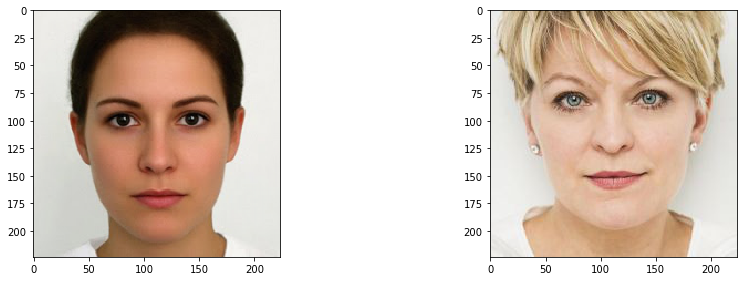

In [4]:
#Prepare some images rescaled to 224 by 224

img_source = load_image(DATA_PATH + 'city/face.jpg')
img_style = load_image(DATA_PATH + 'city/face2.jpeg')

plt.figure(1,figsize=(15, 10))
plt.subplot(221)
plt.imshow(img_source)

plt.subplot(222)
plt.imshow(img_style)
plt.show()

In [5]:
# Create batch to run both images in vgg

batch = [img_source, img_style]

batch1 = img_source.reshape((1, 224, 224, 3))
batch2 = img_style.reshape((1, 224, 224, 3))

batch = np.concatenate((batch1, batch2), 0)

In [6]:
with tf.Session() as sess:
    
    images = tf.placeholder("float", [2, 224, 224, 3])
    feed_dict = {images: batch}

    vgg = vgg19.Vgg19(VGG_PATH + 'vgg19.npy')

    vgg.build(images)

    prob = sess.run(vgg.prob, feed_dict=feed_dict)
    pool5 = sess.run(vgg.pool5, feed_dict=feed_dict)
    conv4_3 = sess.run(vgg.conv4_3, feed_dict=feed_dict)
    conv2_2 = sess.run(vgg.conv2_2, feed_dict=feed_dict)
    
    print_prob(prob[0], VGG_PATH + 'vgg_classes.txt')
    print_prob(prob[1], VGG_PATH + 'vgg_classes.txt')

    sess.close();

npy file loaded
build model started
build model finished: 1s
('Top1: ', 'n03630383 lab coat, laboratory coat', 0.53466457)
('Top5: ', [('n03630383 lab coat, laboratory coat', 0.53466457), ('n04584207 wig', 0.06321238), ('n04317175 stethoscope', 0.061731283), ('n03814906 necklace', 0.035356343), ('n02883205 bow tie, bow-tie, bowtie', 0.02849175)])
('Top1: ', 'n03630383 lab coat, laboratory coat', 0.19723304)
('Top5: ', [('n03630383 lab coat, laboratory coat', 0.19723304), ('n04584207 wig', 0.082110785), ('n04317175 stethoscope', 0.063596539), ('n02892767 brassiere, bra, bandeau', 0.029320227), ('n03476991 hair spray', 0.025211999)])


In [110]:
from sklearn import decomposition  

# Assumes layer is a [2, W, H, C] array
def get_K_repr(K, layer):

    content_maps = layer[0]
    reference_maps = layer[1] 
    
    content_maps = content_maps.reshape(content_maps.shape[0]*content_maps.shape[1], content_maps.shape[2])
    reference_maps = reference_maps.reshape(reference_maps.shape[0]*reference_maps.shape[1], reference_maps.shape[2]).transpose()
    
    res = content_maps.dot(reference_maps)

    estimator = decomposition.NMF(n_components = K, init = 'random', tol=5e-3, random_state=0)    
    W = estimator.fit_transform(res)
    H = estimator.components_
    
    a = layer[0].shape[0]
    
    W = W.reshape(layer[0].shape[0], layer[0].shape[1], K)
    H = H.reshape(K, layer[1].shape[0], layer[1].shape[1])
    
    return W, H

In [203]:
K = 15
Ws, Hs = get_K_repr(K, conv4_3)


plt.figure(figsize=(15, 10))
plt.suptitle('Layer Name')

plt.subplot(16, 2, 1)
plt.imshow(img_source)

plt.gcf().text(0.05, 0.7, "Original ", fontsize=25)

plt.subplot(16, 2, 2)
plt.imshow(img_style)

for i in range(0,K):
        
    plt.gcf().text(0.05, 0.7, "K = " + str(i+1), fontsize=30)

    plt.subplot(16, 2, 2 + 2*i + 1)
    plt.imshow(Ws[:,:,i])
    #plt.colorbar()
    
    plt.subplot(16, 2, 2 + 2*i + 2)
    plt.imshow(Hs[i])
    #plt.colorbar()
    
    #plt.show()


plt.savefig('test.png')
    

(784, 784)

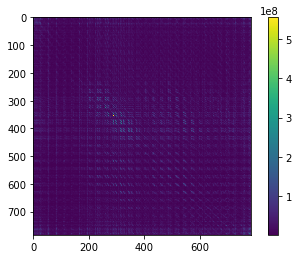

In [11]:
source = conv4_3[0]
style = conv4_3[1] 

source = source.reshape(source.shape[0]*source.shape[1], source.shape[2])
style = style.reshape(style.shape[0]*style.shape[1], style.shape[2]).transpose()

res = source.dot(style)

plt.imshow(res)
plt.colorbar()
res.shape

In [64]:
from sklearn import decomposition  

K = 25

estimator = decomposition.NMF(n_components = K, init = 'random', tol=5e-3, random_state=0)    
W = estimator.fit_transform(res)
H = estimator.components_

'''
plt.imshow(W.dot(H))
plt.colorbar()
'''
W.shape

(784, 25)

849026.916428 822896.101042


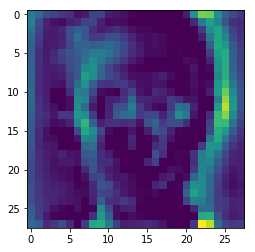

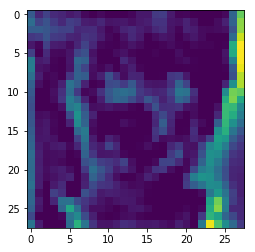

In [72]:
Wreshape = W.reshape(28, 28, 25)
Hreshape = H.reshape(25, 28, 28)
i = 24
plt.imshow(Wreshape[:,:,i])
plt.figure()
plt.imshow(Hreshape[i])
print(Wreshape[:,:,i].sum(), Hreshape[i].sum())

## List of hyperpameters
##### Type of image - Landscape, face, city, indoor, +paintings
##### K = 5, 10, 15, 20, 25, 30
##### Which  VGG layer(s)

Read the paper